In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
data_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## 1. EDA

#### 1.1 fill nan values with the word 'unknown'.

In [4]:
#data_train['keyword'].fillna('unknown', inplace=True)

In [5]:
#data_train['location'].fillna('unknown', inplace=True)

In [6]:
# Clean keywords
def clean_keyword(keyword):
    keyword.fillna('unkown', inplace=True)   # replace NaN with ''
    keyword = keyword.str.replace('%20', ' ')   # replace '%20' with a space
    keyword = keyword.str.replace(r'\s+', ' ', regex=True) # remove extra space
    return keyword

data_train['keyword'] = clean_keyword(data_train['keyword'])
data_test['keyword'] = clean_keyword(data_test['keyword'])

#### 1.2 remove special characters in text 

In [7]:
# remove special characters for keyword column
data_train['keyword'] = data_train['keyword'].str.replace('%20', ' ', regex=False)

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

data_train['clean_text'] = data_train['text'].apply(clean_text)
data_train[:1]

,id,keyword,location,text,target,clean_text
0,1,unkown,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...


In [8]:
# Check which rows still contain unwanted characters
unwanted_pattern = r'[^a-zA-Z\s]'  # Only allow letters, numbers, and spaces

# Apply regex search to all rows
mask = data_train['clean_text'].str.contains(unwanted_pattern)

# Display examples that still have unwanted characters
data_train[mask].head()

,id,keyword,location,text,target,clean_text
3,6,unkown,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
5,8,unkown,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed in ...
12,18,unkown,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1,raining flooding florida tampabay tampa 18 or ...
14,20,unkown,NaN,Damage to school bus on 80 in multi car crash ...,1,damage to school bus on 80 in multi car crash ...
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,barbados bridgetown jamaica ûò two cars set ab...


In [9]:
# Check duplicated text with the same labels
data_train[data_train.duplicated(subset=['clean_text', 'target'])].shape[0]

613

In [10]:
# Drop duplicated text with the same target labels, keep only the first occurrence
data_train = data_train.drop_duplicates(subset = ['clean_text', 'target'])

In [11]:
# Check the number of duplicated text with different target labels
data_train[data_train.duplicated(subset = 'clean_text', keep = False)].shape[0]

146

In [12]:
# Drop duplicated text with the different target labels
data_train = data_train.drop_duplicates(subset = ['clean_text'], keep = False)

In [13]:
data_train.describe()

,id,target
count,6854.000000,6854.000000
mean,5391.967902,0.407791
std,3144.344007,0.491460
min,1.000000,0.000000
25%,2676.250000,0.000000
50%,5292.500000,0.000000
75%,8146.000000,1.000000
max,10866.000000,1.000000


#### 1.3 View how many unique keywords have appeared in text

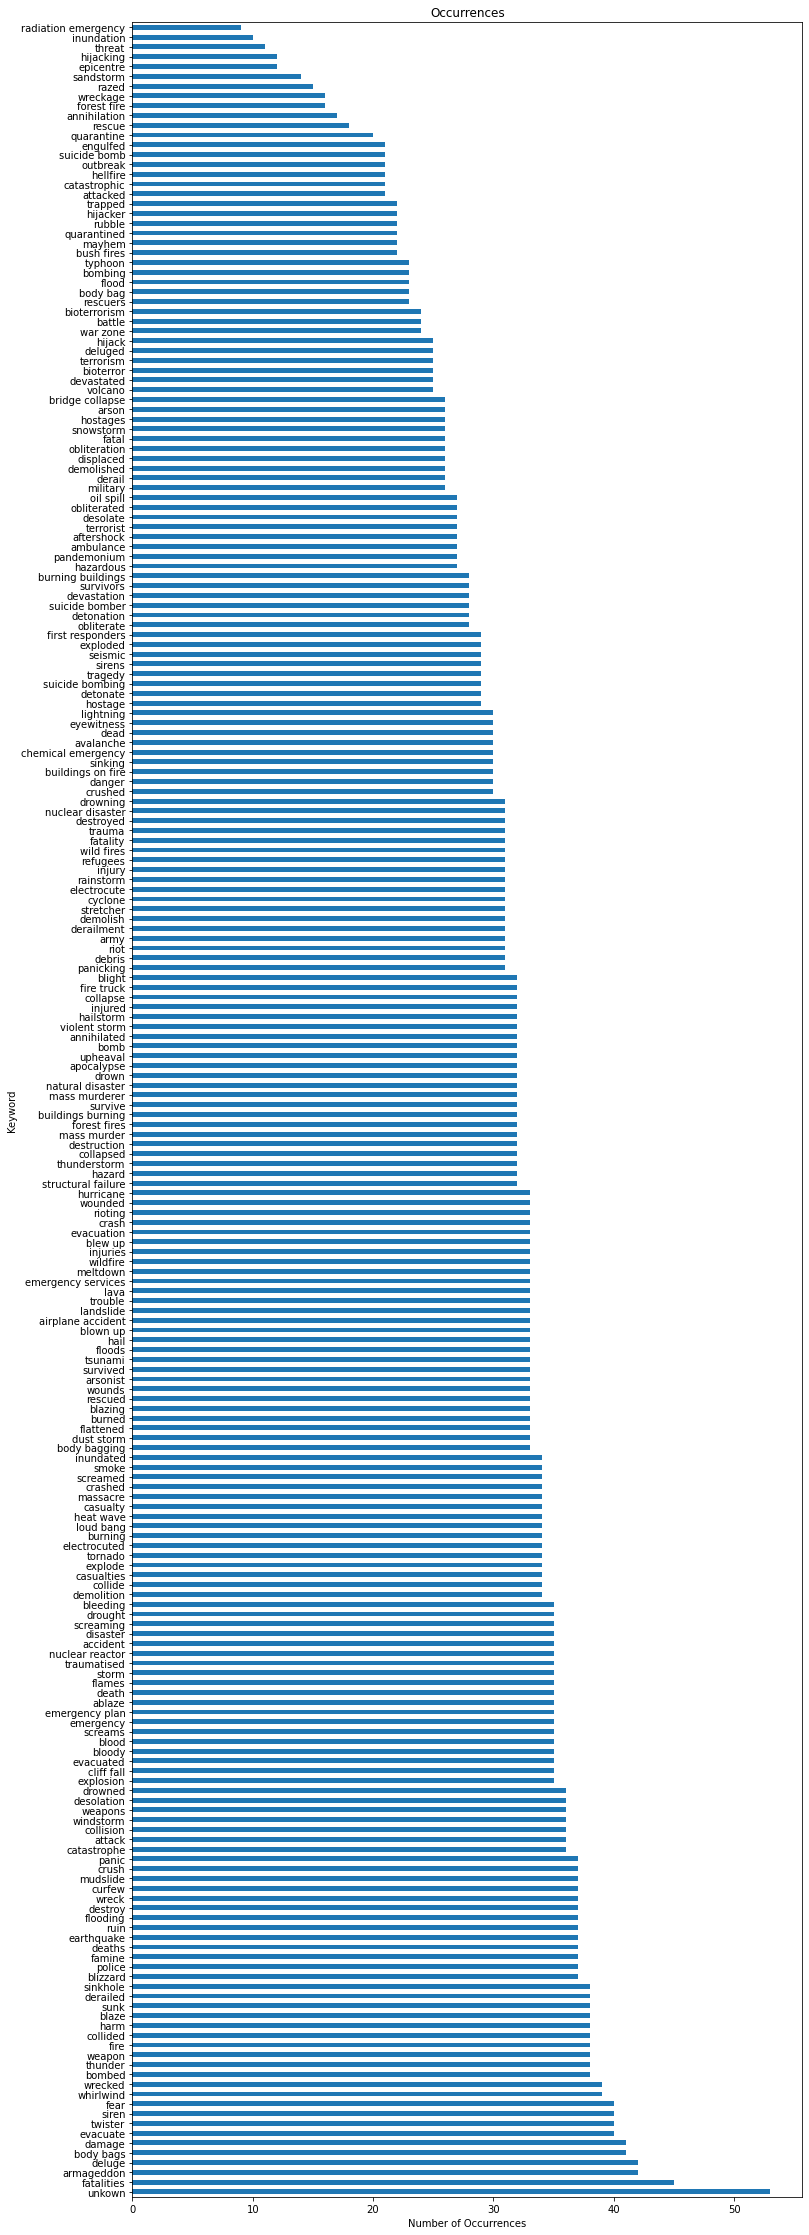

In [14]:
# Count occurrences of each unique keyword
keyword_counts = data_train['keyword'].value_counts()

plt.figure(figsize=(12, 40))
keyword_counts.plot(kind='barh')

plt.xlabel('Number of Occurrences')
plt.ylabel('Keyword')
plt.title('Occurrences')
plt.show()

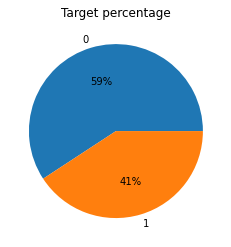

In [15]:
# Visualize the target label
labels = data_train['target'].value_counts().index
values = data_train['target'].value_counts().values

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.title('Target percentage');

### 2. Model building 

#### 2.1 text preprocessing

In [16]:
# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data_train['clean_text'])
sequences = tokenizer.texts_to_sequences(data_train['clean_text'])

# Pad
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y = data_train['target'].values

# model split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2.2 building LSTM model

In [17]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


#### 2.2 Model training

In [18]:
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Train on 4386 samples, validate on 1097 samples
Epoch 1/2
4386/4386 [==============================] - 123s 28ms/sample - loss: 0.6795 - accuracy: 0.5882 - val_loss: 0.6794 - val_accuracy: 0.5834
Epoch 2/2
4386/4386 [==============================] - 114s 26ms/sample - loss: 0.6767 - accuracy: 0.5923 - val_loss: 0.6801 - val_accuracy: 0.5834


#### 2.3 Model evaluation

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

1371/1371 [==============================] - 6s 4ms/sample - loss: 0.6736 - accuracy: 0.5988
Test Accuracy: 0.5988
